In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt('train.csv', delimiter=',',skip_header=1)
data.shape

(42000, 785)

In [3]:
# normalize X
X = (data[:,1:]/255).reshape(-1,28,28,1)
# one hot encode y
y = np.zeros(shape=(len(X),10),dtype=int)
y[np.arange(len(data)),data[:,0].astype(int)] = 1

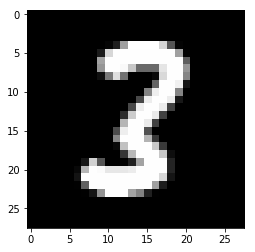

(3, array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]))

In [4]:
# sample image
i = np.random.randint(len(X))
plt.imshow(X[i].reshape(28,28),cmap='gray')
plt.show()
np.argmax(y[i]),y[i]

In [39]:
from keras.models import Model, Sequential
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, Flatten
from keras.layers import Dense, Input, Reshape, ReLU, Conv2DTranspose, Activation

In [87]:
input_layer = Input(shape = X[0].shape)
x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same')(input_layer)
x = LeakyReLU(0.2)(x)
x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
x = LeakyReLU(0.2)(x)
x = Convolution2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
x = LeakyReLU(0.2)(x)
x = Flatten()(x)
output = (Dense(1,activation='sigmoid'))(x)

discriminator = Model(inputs=input_layer,outputs=output)
discriminator.compile(optimizer='adam',loss='binary_crossentropy')

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
batch_normalization_62 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 128)         204928    
__________

In [88]:
input_layer = Input(shape=(1,1,100))
x = Dense(2048)(input_layer)
x = Reshape(target_shape=(4, 4, 128))(x)
x = BatchNormalization(momentum=0.5)(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', output_padding=(0,0))(x)
x = BatchNormalization(momentum=0.5)(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
output = Activation('tanh')(x)

generator = Model(inputs = input_layer,outputs = output)
generator.compile(optimizer='adam',loss='binary_crossentropy')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 1, 1, 100)         0         
_________________________________________________________________
dense_20 (Dense)             (None, 1, 1, 2048)        206848    
_________________________________________________________________
reshape_15 (Reshape)         (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
re_lu_41 (ReLU)              (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 7, 7, 64)          204864    
_________________________________________________________________
batch_normalization_65 (Batc (None, 7, 7, 64)          256       
__________

In [89]:
discriminator.predict(X[:10])

array([[0.5060192 ],
       [0.49922177],
       [0.5068962 ],
       [0.49625048],
       [0.49596238],
       [0.5023812 ],
       [0.49835512],
       [0.50258064],
       [0.50235635],
       [0.49421123]], dtype=float32)

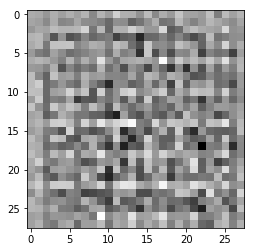

In [90]:
z = np.random.normal(size=(1,1,1,100))

im = generator.predict(z)

plt.imshow(im[0].reshape(28,28),cmap='gray')
plt.show()

In [ ]:
gan = Sequential()
discriminator.trainable = False
gan.add(generator)
gan.add(discriminator)

gan.compile(optimizer='adam',loss='binary_crossentropy')

gan.predict(z)

array([[0.49979314]], dtype=float32)

In [ ]:
epochs = 10
batch_size = 1000
generator_ratio = 2

for epoch in range(epochs):
    print('Epoch: ',epoch)
    for batch in range(len(X)//batch_size):
        print('\tBatch: ',batch)
        # normalize data to -1, 1 (works better that way, also in line with tanh output of generator)
        x_b = X[batch*batch_size:(batch+1)*batch_size]*2-1
        y_b = y[batch*batch_size:(batch+1)*batch_size]
        # randomly generate latent values
        z = np.random.normal(size=((len(x_b),)+(1,1,100)))
        images = generator.predict(z)
        # generate labels for discriminator
        real = np.ones(len(x_b)) # noise? - np.random.random(size=len(x_b))*0.2
        fake = np.zeros(len(x_b)) # noise? + np.random.random(size=len(x_b))*0.2
        
        # train discriminator once
        discriminator.trainable = True
        discriminator.train_on_batch(x_b,real)
        discriminator.train_on_batch(images,fake)
        
        # train generator n times
        for i in range(generator_ratio):
            discriminator.trainable = False
            # generate new images
            # TODO see if I can reuse the images from above
            z = np.random.normal(size=((len(x_b),)+(1,1,100)))
            # discriminator should be fooled into accepting those images
            fool = np.ones(len(x_b)) # noise? - np.random.random(size=len(x_b))*0.2
            gan.train_on_batch(z,fool)

Epoch:  0
	Batch:  0
	Batch:  1
	Batch:  2
	Batch:  3
	Batch:  4
	Batch:  5
	Batch:  6
	Batch:  7
	Batch:  8
	Batch:  9
	Batch:  10
	Batch:  11
	Batch:  12
	Batch:  13
	Batch:  14
	Batch:  15
	Batch:  16
	Batch:  17
	Batch:  18
	Batch:  19
	Batch:  20
	Batch:  21
	Batch:  22
	Batch:  23
	Batch:  24
	Batch:  25
	Batch:  26
	Batch:  27
	Batch:  28
	Batch:  29
	Batch:  30
	Batch:  31
	Batch:  32
	Batch:  33
	Batch:  34
	Batch:  35
	Batch:  36
	Batch:  37
	Batch:  38
	Batch:  39
	Batch:  40
	Batch:  41
Epoch:  1
	Batch:  0
	Batch:  1
	Batch:  2
	Batch:  3
	Batch:  4
	Batch:  5
	Batch:  6
	Batch:  7
	Batch:  8
	Batch:  9
	Batch:  10
	Batch:  11
	Batch:  12
	Batch:  13
	Batch:  14
	Batch:  15
	Batch:  16


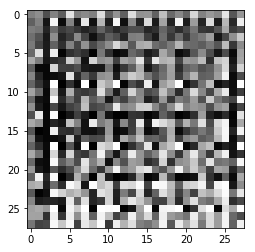

In [86]:
z = np.random.normal(size=(1,1,1,100))

im = generator.predict(z)

plt.imshow(im[0].reshape(28,28),cmap='gray')
plt.show()